# Temporal Causal Inference

In this notebook, we will look at an example of causal effect inference for Temporal Dependencies within a Graphical Causal Model.  We demonstrate the use of temporal shift to normalise temporal datasets and establish causal effects.

Estimating the lag between the parent and action node is quite challenging in temporal causal inference. In this tutorial, we will assume we have the ground truth causal graph as an input.

In [1]:
import networkx as nx
import pandas as pd
from dowhy.utils.timeseries import create_graph_from_csv,create_graph_from_user
from dowhy.utils.plotting import plot, pretty_print_graph

/home/t-ashutoshs/miniconda3/envs/env_dowhy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The user can create a csv file with the edges in the temporal graph. The columns in the csv are node_1, node_2, time_lag which represents an directed edge node_1 -> node_2 with the time lag of time_lag. Let us consider the following graph as the input

| node1  | node2  | time_lag |
|--------|--------|----------|
| V1     | V2     | 3        |
| V2     | V3     | 4        |
| V5     | V6     | 1        |
| V4     | V7     | 4        |
| V7     | V6     | 3        |

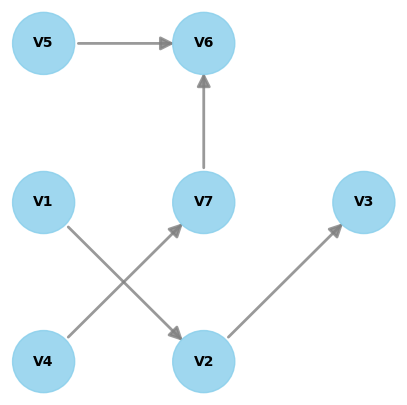

In [2]:
# Input a csv file with the edges in the graph with the columns: node_1,node_2,time_lag
file_path = "../../docs/source/example_notebooks/datasets/temporal_graph.csv"

# Create the graph from the CSV file
graph = create_graph_from_csv(file_path)
plot(graph)

## Dataset Shifting and Filtering

In temporal causal inference, accurately estimating causal effects often requires accounting for time lags between nodes in a graph. For instance, if node_1 influences node_2 with a time lag of 5 timestamps, we represent this dependency as node_1(t-5) -> node_2(t). To maintain this causal relationship in our analysis, we need to shift the columns by the given time lag.

When considering node_2 as the target node, the data for node_1 should be shifted down by 5 timestamps. This adjustment ensures that the new edge node_1(t) -> node_2(t) accurately represents the same lagged dependency as before. Shifting the data in this manner aligns the time series data correctly, allowing us to properly analyze and estimate the causal effects.

In [3]:
from dowhy.timeseries.temporal_shift import find_lagged_parent_nodes,shift_columns,_filter_columns

In [4]:
# read the dataframe in a csv format from the user
dataset_path="../../docs/source/example_notebooks/datasets/temporal_dataset.csv"
dataframe=pd.read_csv(dataset_path)

# the node for which effect estimation has to be done, node:6
target_node = 'V6'

# find the action nodes of the given target node with respective lag times
parents = find_lagged_parent_nodes(graph, target_node)
parents

(['V5', 'V7'], [1.0, 3.0])

In [5]:
time_shifted_df = shift_columns(dataframe,parents[0],parents[1])
time_shifted_df.head()

,V1,V2,V3,V4,V5,V6,V7,V5_lag1,V7_lag1,V7_lag2,V7_lag3
0,1,2,3,4,5,6,7,0,0,0,0
1,2,3,4,5,6,7,8,5,7,0,0
2,3,4,5,6,7,8,9,6,8,7,0
3,4,5,6,7,8,9,10,7,9,8,7
4,0,1,5,7,8,9,7,8,10,9,8


In [6]:
filtered_ts_df = _filter_columns(time_shifted_df,target_node,parents[0])
filtered_ts_df.head()

,V6,V5,V5_lag1,V7,V7_lag1,V7_lag2,V7_lag3
0,6,5,0,7,0,0,0
1,7,6,5,8,7,0,0
2,8,7,6,9,8,7,0
3,9,8,7,10,9,8,7
4,9,8,8,7,10,9,8


## Cause Estimation using Dowhy

Once you have the new dataframe, causal effect estimation can be performed on the target node with respect to the action nodes.

In [7]:
# perform causal effect estimation on this new dataset
import dowhy
from dowhy import CausalModel

model = CausalModel(
    data=filtered_ts_df,
    treatment='V5',
    outcome='V6',
    proceed_when_unidentifiable=True  # Proceed even if the causal graph is not fully identifiable
)

identified_estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 test_significance=True)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d         
─────(E[V₆])
d[V₅]       
Estimand assumption 1, Unconfoundedness: If U→{V5} and U→V6 then P(V6|V5,,U) = P(V6|V5,)

## Realized estimand
b: V6~V5
Target units: ate

## Estimate
Mean value: 0.39256198347107585
p-value: [0.04856244]



/home/t-ashutoshs/miniconda3/envs/env_dowhy/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
/home/t-ashutoshs/home/dowhy/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
